In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import argparse
import matplotlib.pyplot as plt
import os
import cv2
import random

from torchvision import transforms
from PIL import Image
from functools import partial
from collections import defaultdict
from typing import List, Tuple
from functools import partial
from einops import rearrange
from torchvision import models
from typing import List
from torch.utils.data import Dataset
from torchvision import transforms as T
from typing import Callable, Dict, Iterable, List, Tuple, TypeVar

# model parts
from torch.utils.data.distributed import DistributedSampler
import src.dataset.transform as transform
from src.dataset.utils import make_dataset
from src.dataset.classes import get_split_classes, filter_classes

In [17]:
def plot(img):
    img = img.squeeze()
    if img.shape[0] == 3:
        plt.imshow(img.permute(1, 2, 0))
    elif len(img.shape) > 2:
        plt.imshow(img.mean(0))
    else:
        plt.imshow(img)

def plot_list(img_list):
    plt.figure(figsize=(10, 10*len(img_list)), dpi=120)
    for i in range(len(img_list)):
        plt.subplot(1, len(img_list), i+1)
        plt.axis('off')
        plot(img_list[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


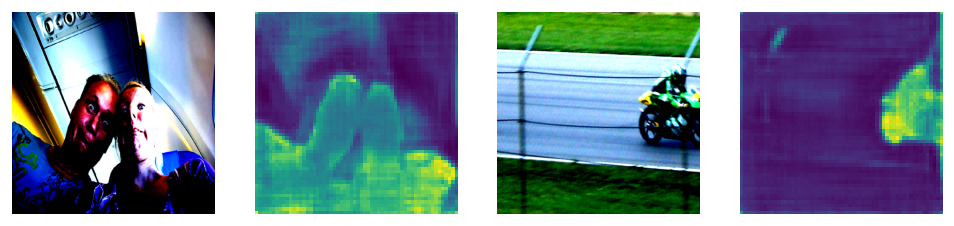

In [18]:
sample_dict = torch.load(f'samples/ep00{6}.bin', map_location='cpu')
plot_list([sample_dict['img_s'], sample_dict['f_s'], sample_dict['img_q'], sample_dict['f_q']])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


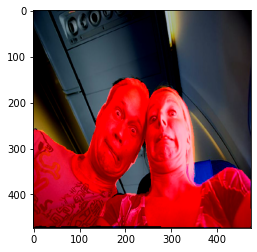

In [48]:
# plot the image with the mask
def mask_img(img, mask, mode):
    '''
    img:（H，W，3）
    mask:（H，W）
    mode: 'R','G','B' red, green, blue
    '''

    mask = mask.reshape(img.shape[0], img.shape[1], 1)
    n = np.zeros(mask.shape)
    if mode == 'R':
        new_img = np.concatenate((mask, n, n), axis = 2)
    elif mode == 'G':
        new_img = np.concatenate((n, mask, n), axis = 2)
    elif mode == 'B':
        new_img = np.concatenate((n, n, mask), axis = 2)
    else:
        return
    
    new_img = new_img + img * 0.3
    
    return new_img



a = mask_img(img, label, 'R')
plt.imshow(a)
plt.show() 

## Dataset

In [2]:
# config node
from src.util import load_cfg_from_cfg_file

args = load_cfg_from_cfg_file('config_files/pascal_aug.yaml')
args.data_root = 'dataset/VOCdevkit/VOC2012'
args.distributed = False

In [3]:
class EpisodicData(Dataset):
    def __init__(self,
                 mode_train: bool,
                 dt_transform: transform.Compose,
                 class_list: List[int],
                 args: argparse.Namespace, data_list, sub_class_file_list):

        self.shot = args.shot
        self.padding = [v*255 for v in args.mean] if args.get('padding')=='avg' else None
        self.meta_aug = args.get('meta_aug', 0)
        self.aug_th = args.get('aug_th', [0.15, 0.30])
        self.aug_type = args.get('aug_type', 0)

        self.random_shot = args.random_shot
        self.data_root = args.data_root
        self.class_list = class_list
        if mode_train:    # args.train_list： txt file 存储 pascal 中所有train_split的file
            self.data_list, self.sub_class_file_list = make_dataset(args.data_root, args.train_list, self.class_list)
        else:
            self.data_list, self.sub_class_file_list = data_list, sub_class_file_list
        self.transform = dt_transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):

        # ====== Read query image + Chose class ======
        image_path, label_path = self.data_list[index]
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.float32(image)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

        if image.shape[0] != label.shape[0] or image.shape[1] != label.shape[1]:
            raise (RuntimeError("Query Image & label shape mismatch: " + image_path + " " + label_path + "\n"))
        label_class = np.unique(label).tolist()
        if 0 in label_class:
            label_class.remove(0)
        if 255 in label_class:
            label_class.remove(255)
        new_label_class = []
        for c in label_class:
            if c in self.class_list:  # current list of classes to try
                new_label_class.append(c)
        label_class = new_label_class
        assert len(label_class) > 0      # 只选取 满足 train/test split的class

        # ====== From classes in query image, chose one randomly ======
        class_chosen = np.random.choice(label_class)
        new_label = np.zeros_like(label)
        ignore_pix = np.where(label == 255)
        target_pix = np.where(label == class_chosen)
        new_label[ignore_pix] = 255
        new_label[target_pix] = 1
        label = new_label

        file_class_chosen = self.sub_class_file_list[class_chosen]     # 当前split 选取的class, 所对应的image/label path
        num_file = len(file_class_chosen)

        # ====== Build support ======
        # First, randomly choose indexes of support images
        support_image_path_list = []
        support_label_path_list = []
        support_idx_list = []

        if self.random_shot:
            shot = random.randint(1, self.shot)
        else:
            shot = self.shot

        for k in range(shot):
            support_idx = random.randint(1, num_file) - 1
            support_image_path = image_path
            support_label_path = label_path
            while((support_image_path == image_path and support_label_path == label_path)   # 排除 query img
                  or support_idx in support_idx_list):
                support_idx = random.randint(1, num_file) - 1
                support_image_path, support_label_path = file_class_chosen[support_idx]
            support_idx_list.append(support_idx)
            support_image_path_list.append(support_image_path)
            support_label_path_list.append(support_label_path)

        support_image_list = []
        support_label_list = []
        subcls_list = [self.class_list.index(class_chosen) + 1]

        # Second, read support images and masks
        for k in range(shot):
            support_image_path = support_image_path_list[k]
            support_label_path = support_label_path_list[k]
            support_image = cv2.imread(support_image_path, cv2.IMREAD_COLOR)
            support_image = cv2.cvtColor(support_image, cv2.COLOR_BGR2RGB)
            support_image = np.float32(support_image)
            support_label = cv2.imread(support_label_path, cv2.IMREAD_GRAYSCALE)
            target_pix = np.where(support_label == class_chosen)
            ignore_pix = np.where(support_label == 255)
            support_label[:, :] = 0
            support_label[target_pix[0], target_pix[1]] = 1
            support_label[ignore_pix[0], ignore_pix[1]] = 255
            if support_image.shape[0] != support_label.shape[0] or support_image.shape[1] != support_label.shape[1]:
                raise (
                    RuntimeError("Support Image & label shape mismatch: "
                                 + support_image_path + " " + support_label_path + "\n")
                )
            support_image_list.append(support_image)
            support_label_list.append(support_label)
        assert len(support_label_list) == shot and len(support_image_list) == shot

        # Original support images and labels
        support_images = support_image_list.copy()
        support_labels = support_label_list.copy()

        # ============== Forward images through transforms
        if self.transform is not None:
            qry_img, target = self.transform(image, label)    # transform query img
            for k in range(shot):                             # transform support img
                if self.meta_aug>1:
                    org_img, org_label = self.transform(support_image_list[k], support_label_list[k])  # flip and resize
                    label_freq = np.bincount(support_label_list[k].flatten())
                    fg_ratio = label_freq[1] / np.sum(label_freq)

                    if self.aug_type == 0:
                        new_img, new_label = self.get_aug_data0(fg_ratio, support_image_list[k], support_label_list[k])
                    elif self.aug_type == 1:
                        new_img, new_label = self.get_aug_data1(fg_ratio, support_image_list[k], support_label_list[k])
                    elif self.aug_type == 3:
                        new_img, new_label = self.get_aug_data3(fg_ratio, support_image_list[k], support_label_list[k])
                    elif self.aug_type == 10:
                        new_img, new_label = self.get_aug_data10(fg_ratio, support_image_list[k], support_label_list[k])

                    if new_img is not None:
                        support_image_list[k] = torch.cat([org_img.unsqueeze(0), new_img], dim=0)
                        support_label_list[k] = torch.cat([org_label.unsqueeze(0), new_label], dim=0)
                    else:
                        support_image_list[k], support_label_list[k] = org_img.unsqueeze(0), org_label.unsqueeze(0)

                else:
                    support_image_list[k], support_label_list[k] = self.transform(support_image_list[k], support_label_list[k])
                    support_image_list[k] = support_image_list[k].unsqueeze(0)
                    support_label_list[k] = support_label_list[k].unsqueeze(0)

        # Reshape properly
        spprt_imgs = torch.cat(support_image_list, 0)
        spprt_labels = torch.cat(support_label_list, 0)

        return qry_img, target, spprt_imgs, spprt_labels, subcls_list, \
               [support_image_path_list, support_labels], [image_path, label]
        # subcls_list  返回的是 选取的class在所有meta train cls list 中的index+1/rank

    def get_aug_data0(self, fg_ratio, support_image, support_label):
        if fg_ratio <= self.aug_th[0]:
            k = 2 if fg_ratio <= 0.03 else 3  # whether to crop at 1/2 or 1/3
            meta_trans = transform.Compose([transform.FitCrop(k=k)] + self.transform.segtransform[-3:])
        elif self.aug_th[0] < fg_ratio < self.aug_th[1]:
            meta_trans = transform.Compose([transform.ColorJitter(cj_type='b')] + self.transform.segtransform[-3:])
        else:
            scale = 473 / max(support_label.shape) * 0.8
            meta_trans = transform.Compose([transform.RandScale(scale=(scale, scale + 0.1), fixed_size=473, padding=self.padding)] +  self.transform.segtransform[-2:])
        new_img, new_label = meta_trans(support_image, support_label)
        return new_img.unsqueeze(0), new_label.unsqueeze(0)

    def get_aug_data10(self, fg_ratio, support_image, support_label):   # only size augmentation, no color augmentation
        if fg_ratio <= self.aug_th[0] or fg_ratio >= self.aug_th[1]:
            if fg_ratio <= self.aug_th[0]:
                k = 2 if fg_ratio <= 0.03 else 3  # whether to crop at 1/2 or 1/3
                meta_trans = transform.Compose([transform.FitCrop(k=k)] + self.transform.segtransform[-3:])
            else:
                scale = 473 / max(support_label.shape) * 0.7
                meta_trans = transform.Compose([transform.RandScale(scale=(scale, scale + 0.1), fixed_size=473, padding=self.padding)] +  self.transform.segtransform[-2:])
            new_img, new_label = meta_trans(support_image, support_label)
            return new_img.unsqueeze(0), new_label.unsqueeze(0)
        else:
            return None, None

In [5]:
def get_train_loader(args, episodic=True, return_path=False):
    """
        Build the train loader. This is a episodic loader.
    """
    assert args.train_split in [0, 1, 2, 3]
    padding = [v*255 for v in args.mean] if args.get('padding')=='avg' else None
    aug_dic = {
        'randscale': transform.RandScale([args.scale_min, args.scale_max]),
        'randrotate': transform.RandRotate(
            [args.rot_min, args.rot_max],
            padding=[0 for x in args.mean],
            ignore_label=255
        ),
        'hor_flip': transform.RandomHorizontalFlip(),
        'vert_flip': transform.RandomVerticalFlip(),
        'crop': transform.Crop(
            [args.image_size, args.image_size], crop_type='rand',
            padding=[0 for x in args.mean], ignore_label=255
        ),
        'resize': transform.Resize(args.image_size, padding=padding),                          # 改了padding
        'resize_np': transform.Resize_np(size=(args.image_size, args.image_size))
    }

    train_transform = [aug_dic[name] for name in args.augmentations]
    train_transform += [transform.ToTensor(), transform.Normalize(mean=args.mean, std=args.std)]
    train_transform = transform.Compose(train_transform)

    split_classes = get_split_classes(args)     # 只用了 args.use_split_coco 这个参数， 返回coco和pascal所有4个split, dict of dict
    class_list = split_classes[args.train_name][args.train_split]['train']   # list of all meta train class labels

    # ====== Build loader ======
    if episodic:
        train_data = EpisodicData(
            mode_train=True, dt_transform=train_transform, class_list=class_list, args=args
        )
    else:
        train_data = StandardData(transform=train_transform, class_list=class_list,
                                  return_paths=return_path,  data_list_path=args.train_list,
                                  args=args)

    world_size = torch.distributed.get_world_size() if args.distributed else 1
    train_sampler = DistributedSampler(train_data) if args.distributed else None
    batch_size = int(args.batch_size / world_size) if args.distributed else args.batch_size

    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        num_workers=args.workers,
        pin_memory=True,
        sampler=train_sampler,
        drop_last=True)
    print("here")
    return train_loader, train_sampler

In [4]:
def get_val_loader(args, data_list, sub_class_list, episodic=True, return_path=False):
    """
        Build the episodic validation loader.
    """
    assert args.test_split in [0, 1, 2, 3, -1, 'default']

    val_trans = [transform.ToTensor(), transform.Normalize(mean=args.mean, std=args.std)]
    if 'resize_np' in args.augmentations:                                                     # base aug 只有 resize
        val_trans = [transform.Resize_np(size=(args.image_size, args.image_size))] + val_trans
    else:
        padding = [v*255 for v in args.mean] if args.get('padding')=='avg' else None
        val_trans = [transform.Resize(args.image_size, padding=padding)] + val_trans
    val_transform = transform.Compose(val_trans)
    val_sampler = None
    split_classes = get_split_classes(args)     # 返回coco和pascal所有4个split, dict of dict

    # ====== Filter out classes seen during training ======
    if args.test_name == 'default':
        test_name = args.train_name    # 'pascal'
        test_split = args.train_split  # split 0
    else:
        test_name = args.test_name
        test_split = args.test_split
    class_list = filter_classes(args.train_name, args.train_split, test_name, test_split, split_classes)  # 只有cross domain时才有用

    # ====== Build loader ======
    if episodic:
        val_data = EpisodicData(mode_train=False, dt_transform=val_transform, class_list=class_list, args=args, data_list=data_list, sub_class_file_list=sub_class_file_list)

        val_loader = torch.utils.data.DataLoader(
            val_data,
            batch_size=1,
            shuffle=False,
            num_workers=args.workers,
            pin_memory=True,
            sampler=val_sampler)
    else:
        class_list = split_classes[args.train_name][args.train_split]['train']
        val_data = StandardData(args, val_transform, class_list=class_list, return_paths=return_path, data_list_path=args.val_list)
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=args.batch_size,
                                                 shuffle=False,
                                                 num_workers=args.workers,
                                                 pin_memory=True,
                                                 sampler=val_sampler)

    return val_loader, val_transform

In [7]:
episodic_val_loader, _ = get_val_loader(args, data_list, sub_class_file_list)

INFO: pascal -> pascal
INFO: 0 -> 0
>> Start Filtering classes 
>> Removed classes = [] 
>> Kept classes = ['airplane', 'bicycle', 'bird', 'boat', 'bottle'] 


In [8]:
iter_val_loader = iter(episodic_val_loader)

In [103]:
for i in iter_val_loader:
    c = i
    break


In [104]:
len(c)

7

## Model

In [9]:
from src.model.pspnet import get_model
from src.model import MMN

In [10]:
# psp backbone
model = get_model(args).cuda()
# load pspnet weight
if args.resume_weights:
    if args.get('wt_file', 0) == 1:
        fname = args.resume_weights + 'without_bias.pth'
    else:
        fname = args.resume_weights + 'with_bias.pth'
    if os.path.isfile(fname):
        print("=> loading weight '{}'".format(fname))
        pre_weight = torch.load(fname)['state_dict']
        model_dict = model.state_dict()

        for index, key in enumerate(model_dict.keys()):
            if 'classifier' not in key and 'gamma' not in key:
                if model_dict[key].shape == pre_weight[key].shape:
                    model_dict[key] = pre_weight[key]
                else:
                    print( 'Pre-trained shape and model shape dismatch for {}'.format(key) )

        model.load_state_dict(model_dict, strict=True)
        print("=> loaded weight '{}'".format(fname))
    else:
        print("=> no weight found at '{}'".format(fname))

=> loading weight './pretrained_models/without_bias.pth'
=> loaded weight './pretrained_models/without_bias.pth'


In [12]:
#  Trans
Trans = MMN(args, agg=args.agg, wa=args.wa, red_dim=args.red_dim).cuda()
# load Trans weight
trans_weight = torch.load('pretrained_models/best.pth')
Trans.load_state_dict(trans_weight['state_dict'])

<All keys matched successfully>

In [108]:
def get_output(args, images, model, Net):

    qry_img, q_label, spt_imgs, s_label, subcls, spprt_oris, qry_oris = images

    if torch.cuda.is_available():
        spt_imgs = spt_imgs.cuda()
        s_label = s_label.cuda()
        q_label = q_label.cuda()
        qry_img = qry_img.cuda()

    # ====== Phase 1: Train a new binary classifier on support samples. ======
    spt_imgs = spt_imgs.squeeze(0)   # [n_shots, 3, img_size, img_size]
    s_label = s_label.squeeze(0).long()  # [n_shots, img_size, img_size]

    # fine-tune classifier
    model.eval()
    with torch.no_grad():
        f_s, fs_lst = model.extract_features(spt_imgs)
        f_q, fq_lst = model.extract_features(qry_img)  # [n_task, c, h, w]

    model.inner_loop(f_s, s_label)
    # ====== Phase 2: Update query score using attention. ======
    with torch.no_grad():
        pred_q0 = model.classifier(f_q)
        pred_q0 = F.interpolate(pred_q0, size=q_label.shape[1:], mode='bilinear', align_corners=True)

    Net.eval()
    with torch.no_grad():
        att_fq = []
        for k in range(args.shot * args.meta_aug):
            single_fs_lst = {key: [ve[k:k + 1] for ve in value] for key, value in fs_lst.items()}
            single_f_s = f_s[k:k + 1]
            _, att_out = Net(fq_lst, single_fs_lst, f_q, single_f_s, )
            att_fq.append(att_out)  # [ 1, 512, h, w]
        att_fq = torch.cat(att_fq, dim=0)
        att_fq = att_fq.mean(dim=0, keepdim=True)
        fq = f_q * (1 - args.att_wt) + att_fq * args.att_wt

        pd_q1 = model.classifier(att_fq)
        pred_q1 = F.interpolate(pd_q1, size=q_label.shape[-2:], mode='bilinear', align_corners=True)
        pd_q = model.classifier(fq)
        pred_q = F.interpolate(pd_q, size=q_label.shape[-2:], mode='bilinear', align_corners=True)
        pred_q2 = F.softmax(pred_q0, dim=1)*(1 - args.att_wt) + F.softmax(pred_q1, dim=1)*args.att_wt

        return pred_q, pred_q0, spt_imgs, s_label, qry_img, q_label

pred, pred0, spt_img, s_label, qry_img, q_label = get_output(args, c, model, Trans)

## Plot

In [54]:
def get_mask_img(img, mask, mode, ratio):
    '''
    img:（H，W，3）
    mask:（H，W）
    mode: 'R','G','B' red, green, blue
    '''

    mask_copy = mask.reshape(img.shape[0], img.shape[1], 1)
    n = np.zeros(mask_copy.shape)
    if mode == 'R':
        new_img = np.concatenate((mask_copy, n, n), axis = 2)
    elif mode == 'G':
        new_img = np.concatenate((n, mask_copy, n), axis = 2)
    elif mode == 'B':
        new_img = np.concatenate((n, n, mask_copy), axis = 2)
    else:
        return
    
    new_img = new_img + img * ratio
    
    return new_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


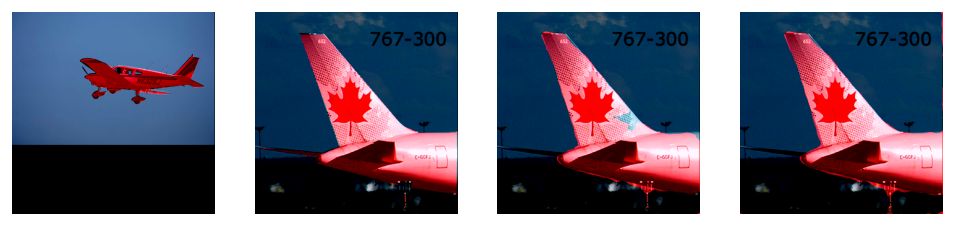

In [110]:
def plot_mask_img(args, images, model, Net, mode, ratio):
    pred, pred0, spt_img, s_label, qry_img, q_label = get_output(args, images, model, Net)
    
    spt_img = rearrange(spt_img.squeeze().detach().cpu().numpy(), 'c h w -> h w c')
    qry_img = rearrange(qry_img.squeeze().detach().cpu().numpy(), 'c h w -> h w c')
    s_label = s_label.squeeze().detach().cpu().numpy()
    q_label = q_label.squeeze().detach().cpu().numpy()
    
    # remove 255 pixels
    q_label_copy = rearrange(q_label, 'h w -> (h w)')
    q_label_copy[np.where(q_label_copy==255)[0]] = 0
    q_label_copy = rearrange(q_label_copy, '(h w) -> h w', h=473)
    
    s_label_copy = rearrange(s_label, 'h w -> (h w)')
    s_label_copy[np.where(s_label_copy==255)[0]] = 0
    s_label_copy = rearrange(s_label_copy, '(h w) -> h w', h=473)
    
    # get pred mask
    mask = np.zeros((473, 473))
    mask = rearrange(mask, 'h w -> (h w)')
    fg = pred.squeeze()[1].detach().cpu().numpy()
    fg = rearrange(fg, 'h w -> (h w)')
    mask[np.where(fg>0)[0]] = 1
    
    # get pred0 mask
    mask0 = np.zeros((473, 473))
    mask0 = rearrange(mask0, 'h w -> (h w)')
    fg0 = pred0.squeeze()[1].detach().cpu().numpy()
    fg0 = rearrange(fg0, 'h w -> (h w)')
    mask0[np.where(fg0>0)[0]] = 1
    
    
    spt_ground_truth = get_mask_img(spt_img, s_label_copy, mode, ratio)
    query_ground_truth = get_mask_img(qry_img, q_label_copy, mode, ratio)
    query_mask_img = get_mask_img(qry_img, mask, mode, ratio)
    query_mask_img0 = get_mask_img(qry_img, mask0, mode, ratio)
    
    img_list = [spt_ground_truth, query_ground_truth, query_mask_img, query_mask_img0]
    
    plt.figure(figsize=(10, 10*len(img_list)), dpi=120)
    for i in range(len(img_list)):
        plt.subplot(1, len(img_list), i+1)
        plt.axis('off')
        plt.imshow(img_list[i])
        
plot_mask_img(args, c, model, Trans, 'R', 0.4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
D:\Softwares\Anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for intege

KeyboardInterrupt: 

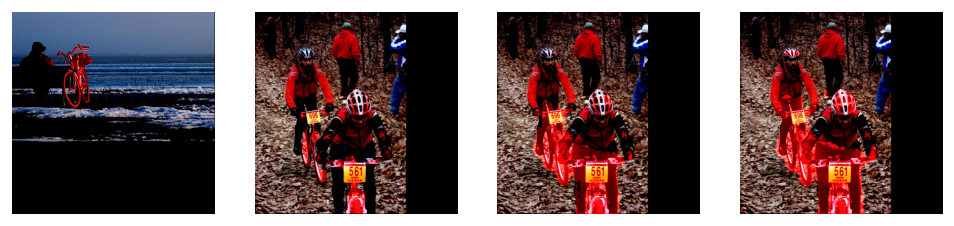

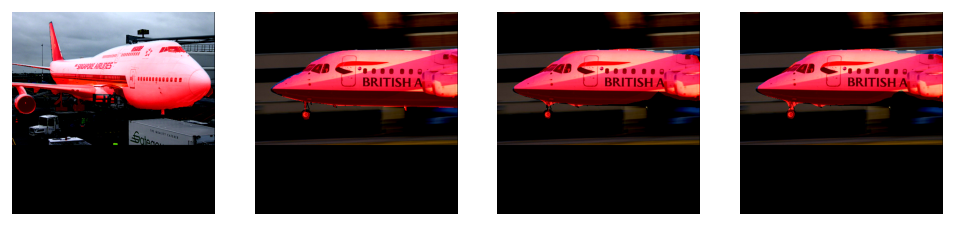

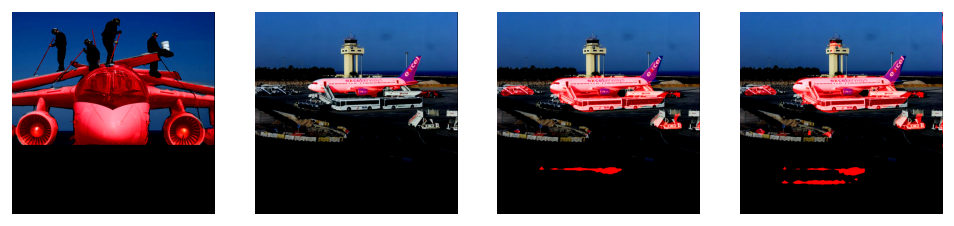

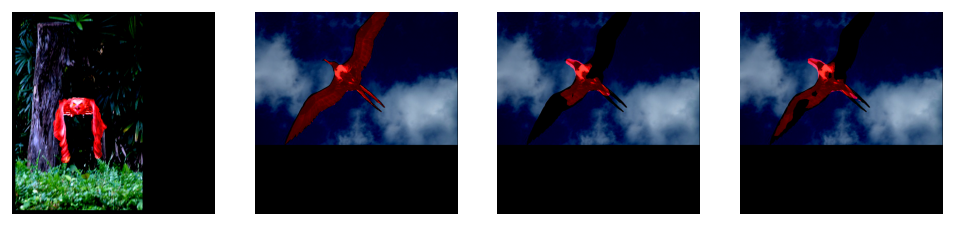

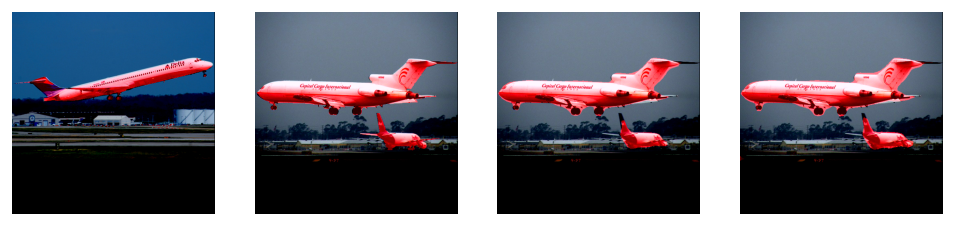

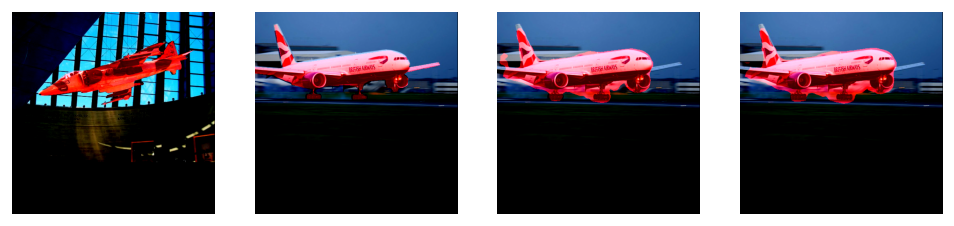

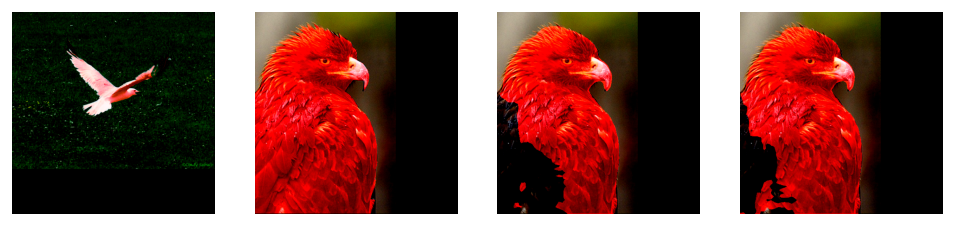

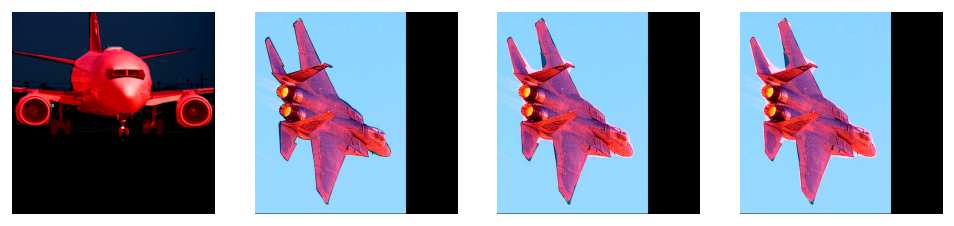

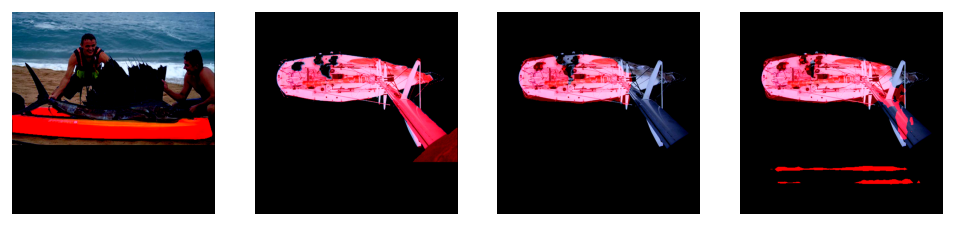

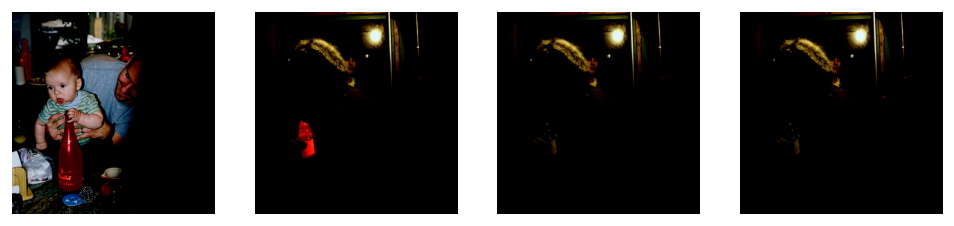

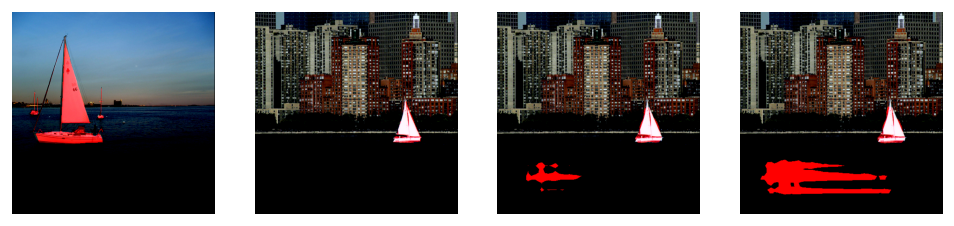

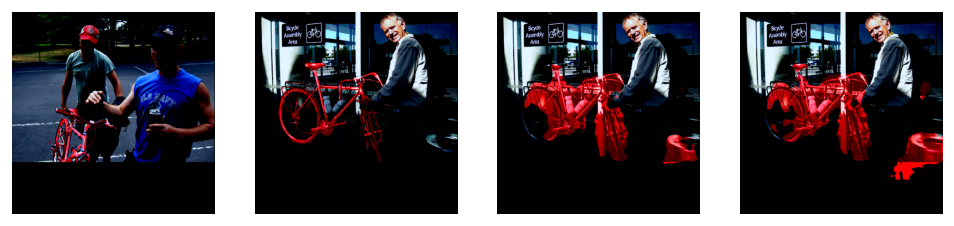

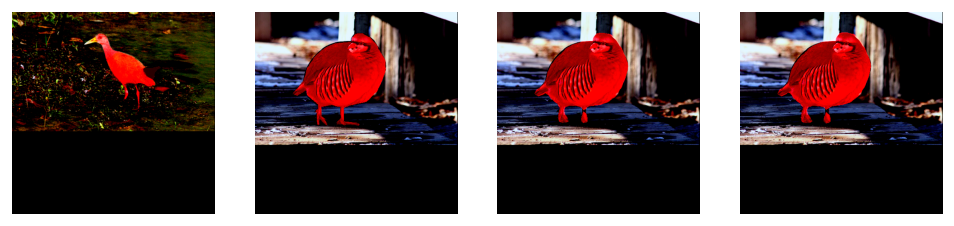

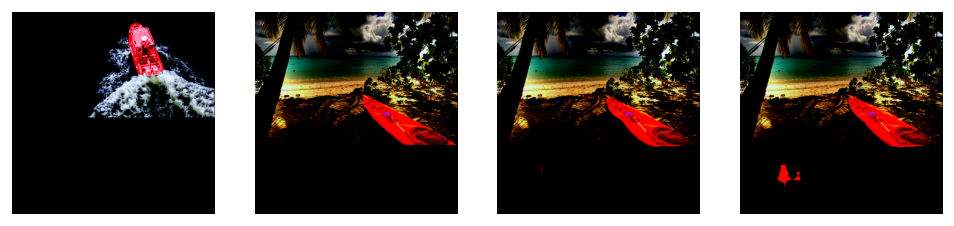

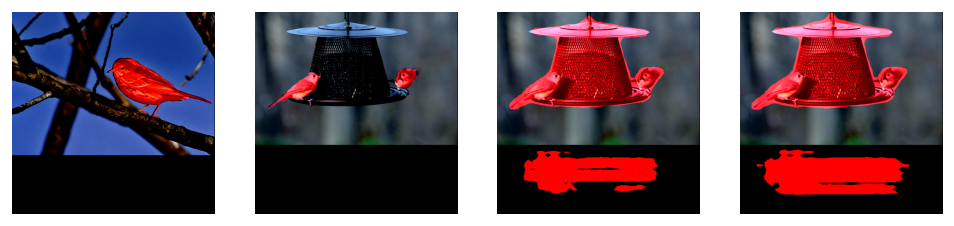

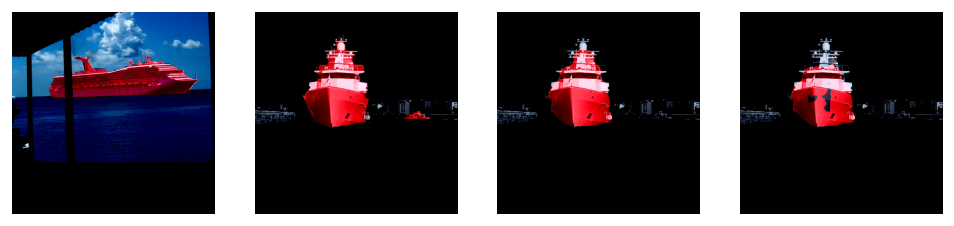

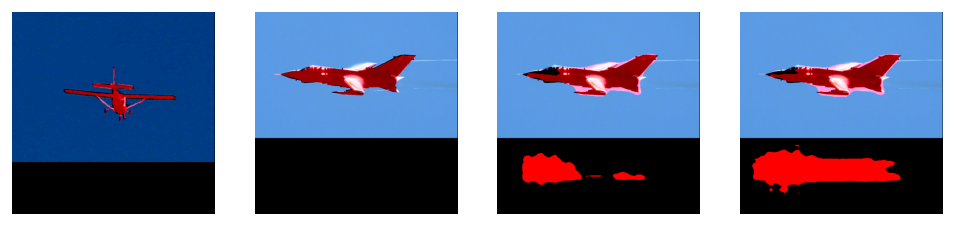

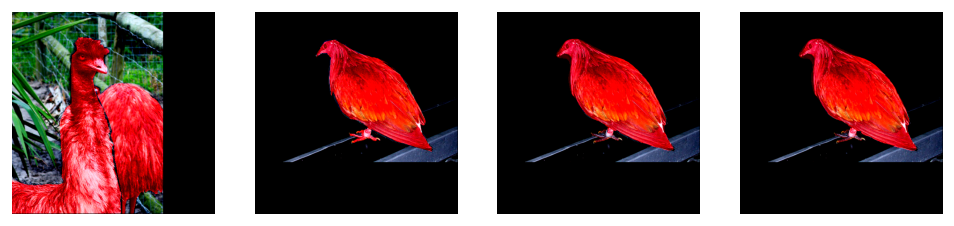

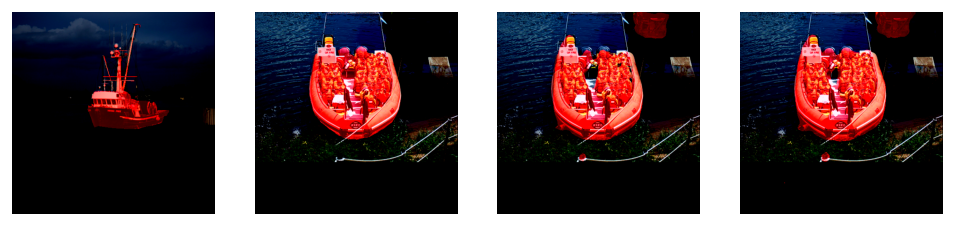

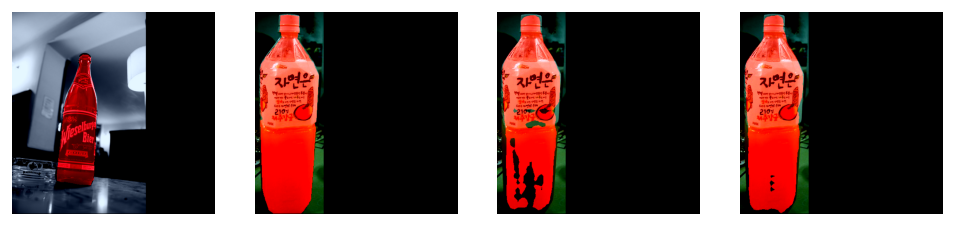

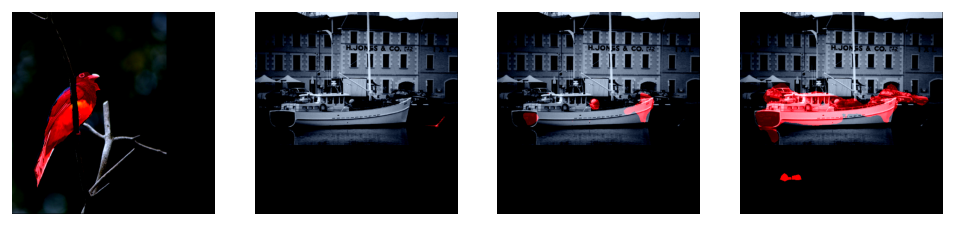

Error in callback <function flush_figures at 0x0000023C7529F4C8> (for post_execute):


KeyboardInterrupt: 

In [111]:
for i in iter_val_loader:
    plot_mask_img(args, i, model, Trans, 'R', 0.4)
    if i == 10:
        break

In [20]:
mask2 = np.zeros((473, 473))
mask2 = rearrange(mask2, 'h w -> (h w)')
fg2 = pred.squeeze()[0].detach().cpu().numpy()
fg2 = rearrange(fg2, 'h w -> (h w)')
mask2[np.where(fg2<0)[0]] = 1
b = get_mask_img(qry_img, mask2, 'R', 0.4)
plt.imshow(b)
plt.show() 

torch.Size([1, 3, 473, 473])

In [ ]:
np.unique(mask2 == mask)

In [ ]:
#     loss_meter = AverageMeter()

#     cls_intersection = defaultdict(int)  # Default value is 0
#     cls_union = defaultdict(int)
#     IoU = defaultdict(float)

#     cls_intersection0 = defaultdict(int)  # Default value is 0
#     cls_union0 = defaultdict(int)
#     IoU0 = defaultdict(float)

#     cls_intersection1 = defaultdict(int)  # Default value is 0
#     cls_union1 = defaultdict(int)
#     IoU1 = defaultdict(float)

#     cls_intersection2 = defaultdict(int)  # Default value is 0
#     cls_union2 = defaultdict(int)
#     IoU2 = defaultdict(float)

#     val_iou_compare = CompareMeter()



        # IoU and loss
        curr_cls = subcls[0].item()  # 当前episode所关注的cls
        for id, (cls_intersection_, cls_union_, IoU_, pred) in \
                enumerate( [(cls_intersection0, cls_union0, IoU0, pred_q0), (cls_intersection1, cls_union1, IoU1, pred_q1),
                 (cls_intersection, cls_union, IoU, pred_q), (cls_intersection2, cls_union2, IoU2, pred_q2)] ):
            intersection, union, target = intersectionAndUnionGPU(pred.argmax(1), q_label, 2, 255)
            intersection, union = intersection.cpu(), union.cpu()
            cls_intersection_[curr_cls] += intersection[1]  # only consider the FG
            cls_union_[curr_cls] += union[1]                # only consider the FG
            IoU_[curr_cls] = cls_intersection_[curr_cls] / (cls_union_[curr_cls] + 1e-10)   # cls wise IoU
            if id==0: iouf0 = intersection[1]/union[1]     # fg IoU for the current episode
            elif id==1: iouf1 = intersection[1]/union[1]

        val_iou_compare.update(iouf1,iouf0)   # compare 当前episode的IoU of att pred and pred0


        criterion_standard = nn.CrossEntropyLoss(ignore_index=255)
        loss1 = criterion_standard(pred_q1, q_label)
        loss_meter.update(loss1.item())

        if (iter_num % 200 == 0):
            mIoU = np.mean([IoU[i] for i in IoU])                                  # mIoU across cls
            mIoU0 = np.mean([IoU0[i] for i in IoU0])
            mIoU1 = np.mean([IoU1[i] for i in IoU1])
            mIoU2 = np.mean([IoU2[i] for i in IoU2])
            log('==> Test: [{}/{}] mIoU0 {:.4f} mIoU1 {:.4f} mIoU {:.4f} mIoU2 {:.4f} Loss {loss_meter.val:.4f} ({loss_meter.avg:.4f}) '.format(
                iter_num, args.test_num, mIoU0, mIoU1, mIoU, mIoU2, loss_meter=loss_meter))

    runtime = time.time() - start_time
    mIoU = np.mean(list(IoU.values()))  # IoU: dict{cls: cls-wise IoU}
    log('mIoU---Val result: mIoU0 {:.4f}, mIoU1 {:.4f} mIoU {:.4f} mIoU2 {:.4f} | time used {:.1f}m.'.format(
        mIoU0, mIoU1, mIoU, mIoU2, runtime/60))
    for class_ in cls_union:
        log("Class {} : {:.4f} for pred0".format(class_, IoU0[class_]))
    log('------Val FG IoU1 compared to IoU0 win {}/{} avg diff {:.2f}'.format(
        val_iou_compare.win_cnt, val_iou_compare.cnt, val_iou_compare.diff_avg))

torch.Size([1, 2, 473, 473])